# Programming assignment 1: Fully-Connected and Convolutional Neural Networks (100 points)
(adapted from the work done by Erik Learned-Miller, which was originally developed by Fei-Fei Li, Andrej Karpathy, and Justin Johnson)

## Overview
<font size='4'> In this assignment you will practice putting together implementations of a Fully-Connected Neural Network and a Convolution Neural Network (CNN) using a modular approach with `Python` and `Numpy`. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead. We will also explore different update rules for optimization.

## Submission format
* <font size='4'>`<your_nu_username>_fc_cnn.ipynb` with your implementations and output.
    
## Note: 
* <font size='4'>Do not install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config file we provide you, so anything that’s not in there by default will probably cause your code to break during grading. Failure to follow any of these instructions will lead to point deductions. 
* <font size='4'>We have some inline questions embedded in the Jupyter notebook files. Do not miss them.

### Setup

In [1]:
from __future__ import print_function
import random
import numpy as np
import time
from utils.data_utils import load_CIFAR10, get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# let's download the data
%cd ../datasets

# 1 -- Linux 
# 2 -- MacOS
# 3 -- Command Prompt on Windows
# 4 -- manually downloading the data
choice = 2


if choice == 1:
    # should work well on Linux and in Powershell on Windows
    !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
elif choice == 2 or choice ==3:
    # if wget is not available for you, try curl
    # should work well on MacOS
    !curl http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz --output cifar-10-python.tar.gz
else:
    print('Please manually download the data from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and put it under the datasets folder.')
!tar -xzvf cifar-10-python.tar.gz

if choice==3:
    !del cifar-10-python.tar.gz
else:
    !rm cifar-10-python.tar.gz

/Users/chuhsuanlin/Documents/NEU/Course/Spring 2023/CS 7150 - Deep Learning/Assignment/Assignment 1/pa1/datasets
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  6802k      0  0:00:24  0:00:24 --:--:-- 7097k
x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1


In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = '../datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


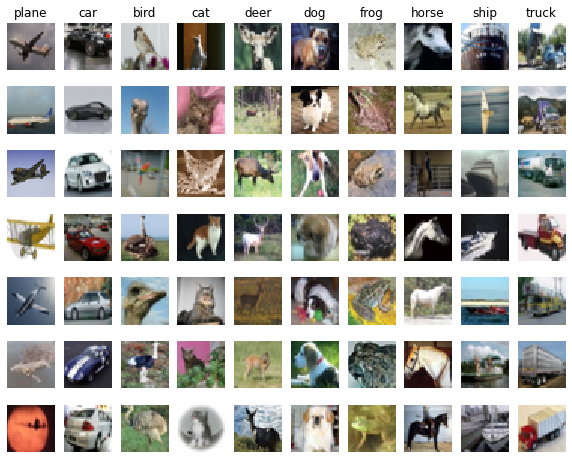

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. 
# Check the get_CIFAR10_data function for more details
data = get_CIFAR10_data(cifar10_dir)
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Programming assignments start here

## Part 1: Fully-connected neural networks (40 points)

### Part 1.1: Linear and non-linear layers

<font size='4' color='red'>**Task 1.1: Affine layer: foward pass (no for loops are allowed) (3 points).**

In [6]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    ###########################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               #
    ###########################################################################
    N = x.shape[0]
    x_reshape = np.reshape(x,(N,-1))
    
    #print(x_reshape.shape, w.shape)
    out = np.dot(x_reshape,w)+b #xw+b
    #print(out.shape)
    #raise NotImplementedError

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b)
    return out, cache

In [7]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769847728806635e-10


<font size='4' color='red'>**Task 1.2: Affine layer: backward pass (no for loops are allowed) (3 points).**
    
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [8]:
def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the affine backward pass.                               #
    ###########################################################################
    N = x.shape[0]
    x_reshape = np.reshape(x,(N,-1))
    
    dx = np.dot(dout,w.T) 
    dx = dx.reshape(x.shape)
    dw = np.dot(x_reshape.T, dout)
    db = np.dot(dout.T,np.ones(N))
    #raise NotImplementedError

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db

In [9]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


<font size='4' color='red'>**Task 1.3: ReLU activation: forward pass (no for loops are allowed) (2 points).**
    
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [10]:
def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass.                                  #
    ###########################################################################
    out = np.maximum(0,x)
    #raise NotImplementedError
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache

In [11]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


<font size='4' color='red'>**Task 1.4: ReLU activation: backward pass (no for loops are allowed) (2 points).**
    
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [12]:
def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass.                                 #
    ###########################################################################
    
    dx = np.copy(dout)
    dx[x<=0] = 0
    #raise NotImplementedError

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx

In [13]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


<font size='4' color='red'>**Task 1.5: Softmax loss layer (no for loops are allowed) (4 points).**

In [14]:
def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """

    ###########################################################################
    # TODO: Implement the softmax_loss function,                              #
    # including the forward and backward passes.                              #
    ###########################################################################
    N = x.shape[0]
    x_= x-np.max(x, axis=1, keepdims=True)
    p = np.exp(x_)/np.sum(np.exp(x_), axis=1, keepdims=True)
    loss = np.mean(-np.log(p[np.arange(N), y]))
    
    dx = np.copy(p)
    dx[np.arange(N), y] -= 1
    dx /= N
    
    #raise NotImplementedError

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return loss, dx

In [15]:
# Let's check your implementation
np.random.seed(5330)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)
#print(x,y)
dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.302800487936905
dx error:  9.169036489219965e-09


### Part 1.2: Fully-Connected Neural Networks

<font size='4' color='red'>**Task 1.6: Two-layer network (no for loops are allowed in your implementation) (6 points)**
    
<font size='4'>Complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [32]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10,
                 weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        
        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with first layer weights                         #
        # and biases using the keys 'W1' and 'b1' and second layer                 #
        # weights and biases using the keys 'W2' and 'b2'.                         #
        ############################################################################
        self.params['W1'] = np.random.normal(loc=0, scale=weight_scale, size=(input_dim, hidden_dim))
        self.params['W2'] = np.random.normal(loc=0, scale=weight_scale, size=(hidden_dim, num_classes))
        self.params['b1'] = np.zeros(hidden_dim)
        self.params['b2'] = np.zeros(num_classes)
          
        
        #raise NotImplementedError
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################


    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        
        out1, cache1 = affine_forward(X, self.params['W1'], self.params['b1'])
        out2, cache2 = relu_forward(out1)
        out3, cache3 = affine_forward(out2, self.params['W2'], self.params['b2'])        
        scores = out3 
        
        #raise NotImplementedError

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
         
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization!                   #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        loss, dscore = softmax_loss(out3, y)
        loss += 0.5*self.reg*np.sum(self.params['W2']**2)+ 0.5*self.reg*np.sum(self.params['W1']**2)

        
        dx, grads['W2'], grads['b2'] = affine_backward(dscore, cache3)
        dx = relu_backward(dx, cache2)
        dx, grads['W1'], grads['b1'] = affine_backward(dx, cache1)
        
        grads['W2'] += self.reg*grads['W2']
        grads['W1'] += self.reg*grads['W1']
        #raise NotImplementedError
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

In [33]:
# Let's check your implementation
np.random.seed(5330)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.22e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 1.00e+00
W2 relative error: 1.00e+00
b1 relative error: 1.09e-09
b2 relative error: 9.09e-10


<font size='4' color='red'>**Task 1.7: Solver (2 points).**
    
<font size='4'>Following a more modular design, we have split the logic for training models into a separate class.

<font size='4'>Open the file `pa4_code/utils/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that <font color='red'>achieves at least `50%` accuracy on the validation set.

In [34]:
from utils.solver import Solver

model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################

data=data
solver = Solver(model, data,
                update_rule='sgd',
                optim_config={
                  'learning_rate': 1e-3,
                },
                lr_decay=0.95,
                num_epochs=10, batch_size=200,
                print_every=100)
solver.train()
    
#raise NotImplementedError

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 2450) loss: 2.301839
(Epoch 0 / 10) train acc: 0.140000; val_acc: 0.147000
(Iteration 101 / 2450) loss: 1.809113
(Iteration 201 / 2450) loss: 1.620563
(Epoch 1 / 10) train acc: 0.415000; val_acc: 0.428000
(Iteration 301 / 2450) loss: 1.503793
(Iteration 401 / 2450) loss: 1.593555
(Epoch 2 / 10) train acc: 0.466000; val_acc: 0.461000
(Iteration 501 / 2450) loss: 1.461211
(Iteration 601 / 2450) loss: 1.507400
(Iteration 701 / 2450) loss: 1.447803
(Epoch 3 / 10) train acc: 0.505000; val_acc: 0.467000
(Iteration 801 / 2450) loss: 1.464455
(Iteration 901 / 2450) loss: 1.399541
(Epoch 4 / 10) train acc: 0.526000; val_acc: 0.490000
(Iteration 1001 / 2450) loss: 1.387980
(Iteration 1101 / 2450) loss: 1.337905
(Iteration 1201 / 2450) loss: 1.279378
(Epoch 5 / 10) train acc: 0.530000; val_acc: 0.489000
(Iteration 1301 / 2450) loss: 1.280975
(Iteration 1401 / 2450) loss: 1.237095
(Epoch 6 / 10) train acc: 0.544000; val_acc: 0.507000
(Iteration 1501 / 2450) loss: 1.150543
(Iteration

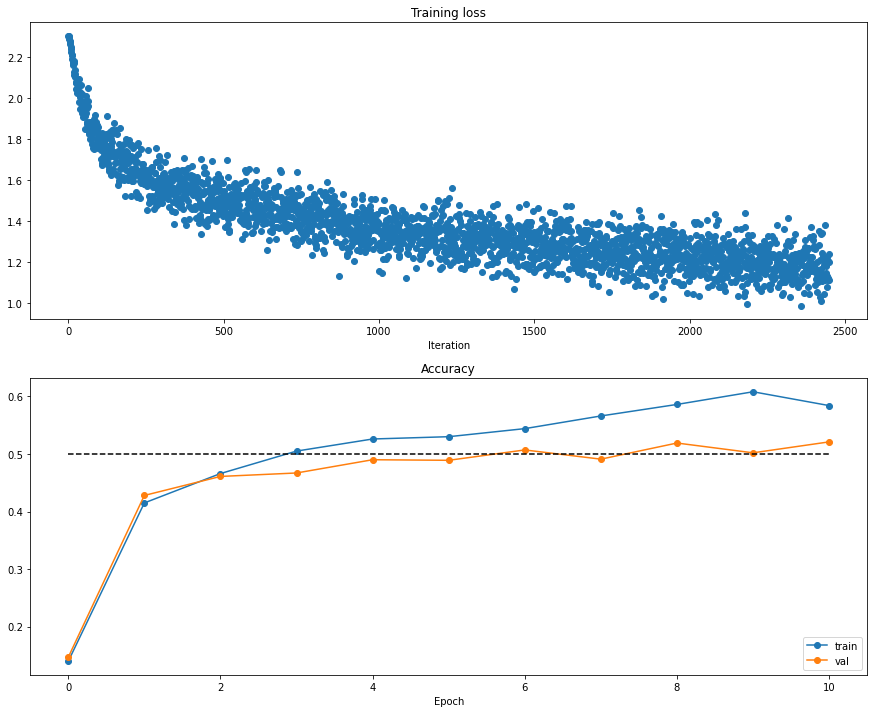

In [35]:
# Run this cell to visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

<font size='4' color='red'>**Task 1.8: Multilayer network (8 points).**
    
<font size='4'>Next you will implement a fully-connected network with an arbitrary number of hidden layers.

<font size='4'>Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch/layer normalization.

In [36]:
hidden_dims=5
for i in range(1, hidden_dims+1):
    W_name = 'W'+str(i)
    b_bame = 'b'+str(i)
    
    print(W_name)

W1
W2
W3
W4
W5


In [37]:
def affine_relu_forward(x,w,b):
    
    out, cache_aff = affine_forward(x,w,b)
    out, cache_relu = relu_forward(out)
    
    return out, (cache_aff, cache_relu)

def affine_relu_backward(dout, cache):
    
    cache_aff, cache_relu = cache
    dx = relu_backward(dout, cache_relu)
    dx, dw, db = affine_backward(dx, cache_aff)
    
    return dx, dw, db
    

In [42]:
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. For a network with L layers,
    the architecture will be

    {affine - relu} x (L - 1) - affine - softmax

    where batch/layer normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10, reg=0.0,
                 weight_scale=1e-2, dtype=np.float32, seed=None):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}
        self.cache = {}
        
        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution centered at 0 with standard       #
        # deviation equal to weight_scale. Biases should be initialized to zero.   #
        ############################################################################
        
        dims = [input_dim]+hidden_dims+[num_classes]
        
        for i in range(1, self.num_layers+1):
            W_name = 'W'+str(i)
            b_bame = 'b'+str(i)
            #c_name = 'c'+str(i)
            
            # first layer
            self.params[W_name] = np.random.normal(loc=0, scale=weight_scale, size=(dims[i-1], dims[i]))
            self.params[b_bame] = np.zeros(dims[i])
            
            
            #self.cach['c1'] = {}

            # hidden layer
        
            
            
            #self.params[W_name] = np.random.normal(loc=0, scale=weight_scale, size=(hidden_dim, hidden_dim))
            #self.params[b_bame] = np.zeros(hidden_dim)
            #self.cach[c_name] = {}
         
            # output layer
            #W_name = 'W'+str(self.num_layers)
            #b_bame = 'b'+str(self.num_layers)
            #c_name = 'c'+str(self.num_layers)
            #self.params[W_name] = np.random.normal(loc=0, scale=weight_scale, size=(hidden_dim, num_classes))
            #self.params[b_bame] = np.zeros(num_classes)
            #self.cach[c_name] = {}
        
        #raise NotImplementedError
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = 'test' if y is None else 'train'

        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        ############################################################################
        
        for i in range(1, self.num_layers+1):
            W_name = 'W'+str(i)
            b_bame = 'b'+str(i)
            c_name = 'c'+str(i)
            
            if i==1:
                out, self.cache[c_name] = affine_relu_forward(X, self.params[W_name], self.params[b_bame])
                #out, self.params[c_name] = relu_forward(out)
            elif i==self.num_layers:
                out, self.cache[c_name] = affine_forward(out, self.params[W_name], self.params[b_bame])
            else:
                out, self.cache[c_name] = affine_relu_forward(out, self.params[W_name], self.params[b_bame])
                #out, self.params[c_name] = relu_forward(out)
                    
                   
        scores = out
        
        
        #raise NotImplementedError
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early
        if mode == 'test':
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        
        loss, dscore = softmax_loss(out, y)
        
        for i in range(self.num_layers, 0, -1):
            #print(i)
            W_name = 'W'+str(i)
            b_bame = 'b'+str(i)
            c_name = 'c'+str(i)
            
            loss += 0.5*self.reg*np.sum(self.params[W_name]**2)

            if i == self.num_layers:
                dx, grads[W_name], grads[b_bame] = affine_backward(dscore, self.cache[c_name])

            else:       
                #dx = relu_backward(dx, self.params[c_name])
                dx, grads[W_name], grads[b_bame] = affine_relu_backward(dx, self.cache[c_name])
                
            grads[W_name] += self.reg*grads[W_name]
        #raise NotImplementedError
    
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################
        #print(grads)
        return loss, grads


In [43]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet(
        [H1, H2], 
        input_dim=D, 
        num_classes=C,
        reg=reg, 
        weight_scale=5e-2, 
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)
  
    # Most of the errors should be on the order of 1e-7 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of 1e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.300479089768492
W1 relative error: 1.03e-07
W2 relative error: 2.21e-05
W3 relative error: 4.56e-07
b1 relative error: 4.66e-09
b2 relative error: 2.09e-09
b3 relative error: 1.69e-10
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 1.00e+00
W2 relative error: 1.00e+00
W3 relative error: 1.00e+00
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 2.38e-10


<font size='4' color='red'>**Task 1.9: Overfitting a small dataset (2 points).**

<font size='4'>As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the learning rate and initialization scale to overfit and achieve 100% training accuracy within 20 epochs.

/Users/chuhsuanlin/opt/anaconda3/envs/cs7150_pa1/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


(Iteration 1 / 40) loss: inf
(Epoch 0 / 20) train acc: 0.060000; val_acc: 0.096000
(Epoch 1 / 20) train acc: 0.120000; val_acc: 0.093000
(Epoch 2 / 20) train acc: 0.200000; val_acc: 0.098000
(Epoch 3 / 20) train acc: 0.280000; val_acc: 0.098000
(Epoch 4 / 20) train acc: 0.380000; val_acc: 0.110000
(Epoch 5 / 20) train acc: 0.480000; val_acc: 0.105000
(Iteration 11 / 40) loss: 35.383493
(Epoch 6 / 20) train acc: 0.560000; val_acc: 0.100000
(Epoch 7 / 20) train acc: 0.540000; val_acc: 0.118000
(Epoch 8 / 20) train acc: 0.740000; val_acc: 0.110000
(Epoch 9 / 20) train acc: 0.820000; val_acc: 0.111000
(Epoch 10 / 20) train acc: 0.820000; val_acc: 0.104000
(Iteration 21 / 40) loss: 7.022045
(Epoch 11 / 20) train acc: 0.740000; val_acc: 0.107000
(Epoch 12 / 20) train acc: 0.800000; val_acc: 0.113000
(Epoch 13 / 20) train acc: 0.900000; val_acc: 0.109000
(Epoch 14 / 20) train acc: 0.880000; val_acc: 0.111000
(Epoch 15 / 20) train acc: 0.960000; val_acc: 0.108000
(Iteration 31 / 40) loss: 1.25

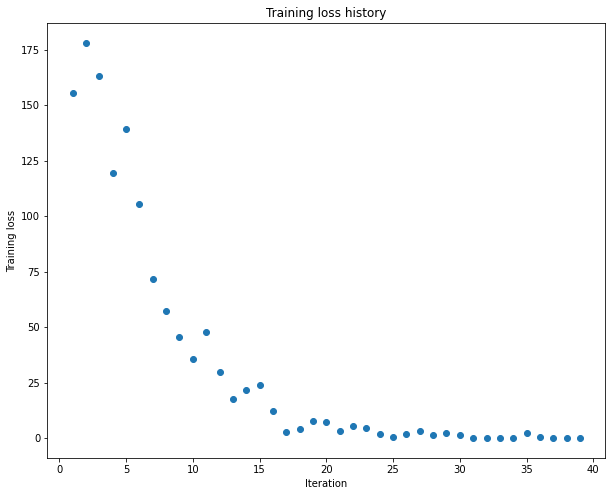

In [99]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

#############################################################
# tweaking just the learning rate and initialization scale.
#############################################################

weight_scale = 1e-1
learning_rate = 1e-4

#############################################################
#                 end of your tweaking                      #
#############################################################

#model = TwoLayerNet()

model= FullyConnectedNet(
    [100,100],
    weight_scale=weight_scale, 
    dtype=np.float64
)

solver = Solver(
    model, small_data,
    print_every=10, num_epochs=20, batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate,}
)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

<font size='4' color='red'>**Task 1.10: Overfitting a small dataset with a five-layer network (2 points).**
    
<font size='4'>Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 152.003521
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.076000
(Epoch 1 / 20) train acc: 0.260000; val_acc: 0.117000
(Epoch 2 / 20) train acc: 0.200000; val_acc: 0.120000
(Epoch 3 / 20) train acc: 0.460000; val_acc: 0.121000
(Epoch 4 / 20) train acc: 0.640000; val_acc: 0.132000
(Epoch 5 / 20) train acc: 0.700000; val_acc: 0.120000
(Iteration 11 / 40) loss: 10.076011
(Epoch 6 / 20) train acc: 0.760000; val_acc: 0.131000
(Epoch 7 / 20) train acc: 0.800000; val_acc: 0.128000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.120000
(Epoch 9 / 20) train acc: 0.960000; val_acc: 0.126000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.127000
(Iteration 21 / 40) loss: 0.035979
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.129000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.134000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.135000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.135000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.136000
(Iteration 31 / 40) los

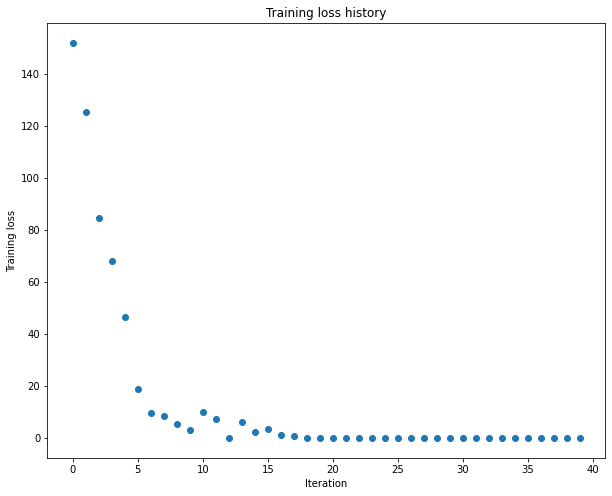

In [100]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


#############################################################
# tweaking just the learning rate and initialization scale.
#############################################################

weight_scale = 1e-1
learning_rate = 1e-3

#############################################################
#                 end of your tweaking                      #
#############################################################

model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale, 
    dtype=np.float64
)

solver = Solver(
    model, small_data,
    print_every=10, num_epochs=20, batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate,}
)
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

<font size='4' color='red'>**Inline Question 1.11 (1 points):** 
    
<font size='4' color='red'>**Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?**

<font size='4'>**Answer:**
    
[FILL THIS IN]


<font size='4' color='red'>**Task 1.12: SGD+Momentum (2 points)**
    
<font size='4'>Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent.

<font size='4'>Open the file `pa1_code/utils/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule below and run the following to check your implementation. You should see errors less than 1e-8.

In [121]:
def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a
      moving average of the gradients.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)
    config.setdefault('momentum', 0.9)
    v = config.get('velocity', np.zeros_like(w))
    
    next_w = None
    ###########################################################################
    # TODO: Implement the momentum update formula. Store the updated value in #
    # the next_w variable. You should also use and update the velocity v.     #
    ###########################################################################
    v = config['momentum']*v-config['learning_rate']*dw
    next_w = w+v
    
    #raise NotImplementedError

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    config['velocity'] = v

    return next_w, config

In [122]:
# Let's check your implementation
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


running with  sgd
(Iteration 1 / 200) loss: 2.639537
(Epoch 0 / 5) train acc: 0.113000; val_acc: 0.103000
(Iteration 11 / 200) loss: 2.189289
(Iteration 21 / 200) loss: 2.107316
(Iteration 31 / 200) loss: 2.224142
(Epoch 1 / 5) train acc: 0.252000; val_acc: 0.240000
(Iteration 41 / 200) loss: 2.031852
(Iteration 51 / 200) loss: 1.831134
(Iteration 61 / 200) loss: 1.983326
(Iteration 71 / 200) loss: 1.911296
(Epoch 2 / 5) train acc: 0.335000; val_acc: 0.291000
(Iteration 81 / 200) loss: 1.985163
(Iteration 91 / 200) loss: 1.783338
(Iteration 101 / 200) loss: 1.967279
(Iteration 111 / 200) loss: 1.648203
(Epoch 3 / 5) train acc: 0.357000; val_acc: 0.304000
(Iteration 121 / 200) loss: 1.952687
(Iteration 131 / 200) loss: 1.605681
(Iteration 141 / 200) loss: 1.748757
(Iteration 151 / 200) loss: 1.746692
(Epoch 4 / 5) train acc: 0.401000; val_acc: 0.321000
(Iteration 161 / 200) loss: 1.572103
(Iteration 171 / 200) loss: 1.760374
(Iteration 181 / 200) loss: 1.776143
(Iteration 191 / 200) los

/Users/chuhsuanlin/opt/anaconda3/envs/cs7150_pa1/lib/python3.6/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/chuhsuanlin/opt/anaconda3/envs/cs7150_pa1/lib/python3.6/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/chuhsuanlin/opt/anaconda3/envs/cs7150_pa1/lib/python3.6/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Addin

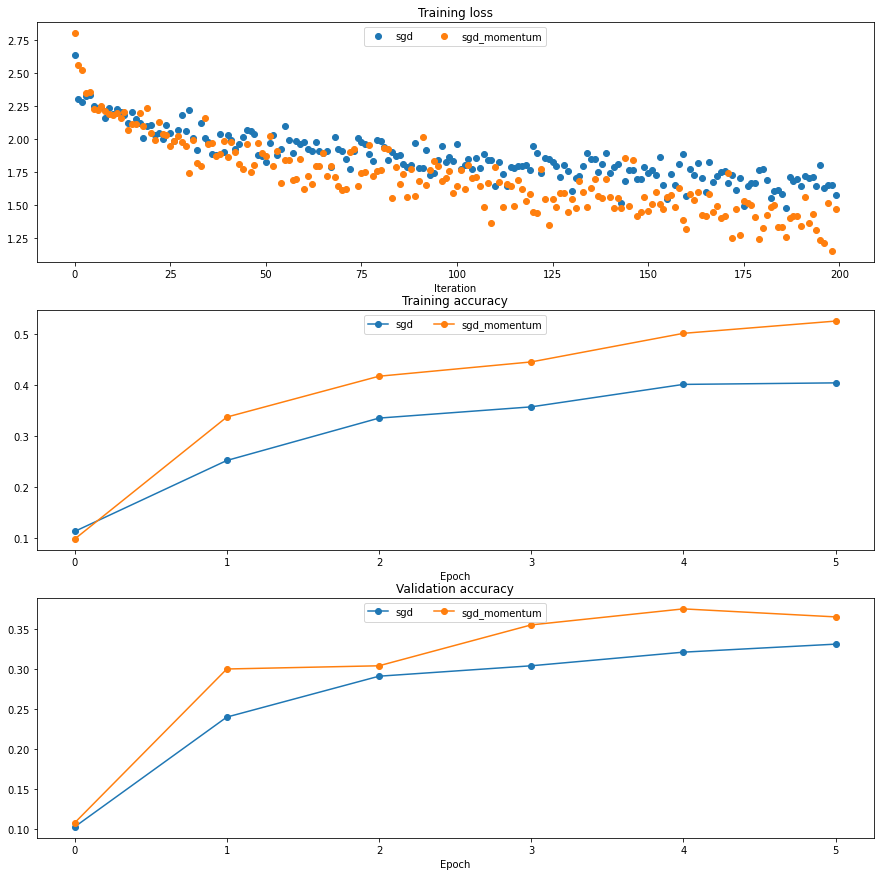

In [123]:
# Run the following to train a six-layer network with both SGD and SGD+momentum. 
# You should see the SGD+momentum update rule converge faster.
from utils.solver import Solver

num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(
        model, small_data,
        num_epochs=5, batch_size=100,
        update_rule=update_rule if update_rule == 'sgd' else sgd_momentum,
        optim_config={'learning_rate': 1e-2,},
        verbose=True
    )

    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

<font size='4' color='red'>**Task 1.13: Train a good model! (3 points)**
    
<font size='4'>Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. <font color='red'>We require you to get at least 50% accuracy on the validation set using a fully-connected net within 50 epochs.

<font size='4'>If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. 

(Iteration 1 / 690) loss: 2.361438
(Epoch 0 / 30) train acc: 0.119000; val_acc: 0.134000
(Epoch 1 / 30) train acc: 0.278000; val_acc: 0.261000
(Epoch 2 / 30) train acc: 0.355000; val_acc: 0.376000
(Epoch 3 / 30) train acc: 0.373000; val_acc: 0.404000
(Epoch 4 / 30) train acc: 0.410000; val_acc: 0.435000
(Epoch 5 / 30) train acc: 0.476000; val_acc: 0.447000
(Epoch 6 / 30) train acc: 0.458000; val_acc: 0.460000
(Epoch 7 / 30) train acc: 0.517000; val_acc: 0.473000
(Epoch 8 / 30) train acc: 0.504000; val_acc: 0.464000
(Epoch 9 / 30) train acc: 0.488000; val_acc: 0.492000
(Epoch 10 / 30) train acc: 0.540000; val_acc: 0.496000
(Epoch 11 / 30) train acc: 0.505000; val_acc: 0.466000
(Epoch 12 / 30) train acc: 0.521000; val_acc: 0.490000
(Epoch 13 / 30) train acc: 0.530000; val_acc: 0.492000
(Epoch 14 / 30) train acc: 0.516000; val_acc: 0.477000
(Epoch 15 / 30) train acc: 0.553000; val_acc: 0.484000
(Epoch 16 / 30) train acc: 0.545000; val_acc: 0.487000
(Epoch 17 / 30) train acc: 0.551000; val

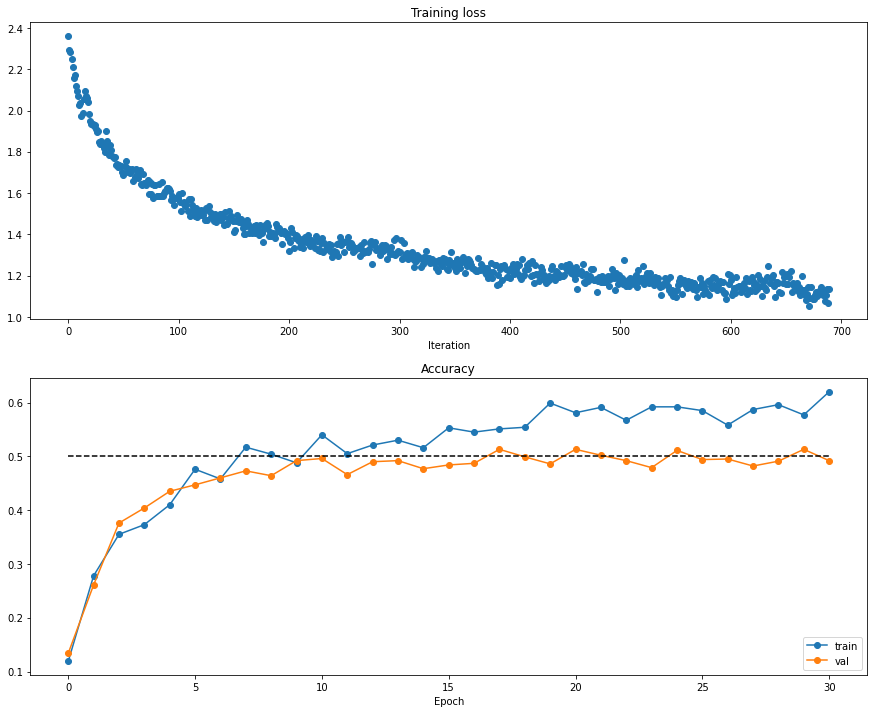

In [157]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
#best_model = FullyConnectedNet()

weight_scale = 5e-2
learning_rate = 1e-1

best_model = FullyConnectedNet(
    [50, 75, 100, 75, 50],
    weight_scale=weight_scale, 
    dtype=np.float64
)


solver = Solver(
    best_model, data,
    print_every=500, num_epochs=30, batch_size=2048,
    update_rule=sgd_momentum,
    optim_config={'learning_rate': learning_rate,}
)
solver.train()


plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [ ]:
# Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

## Part 2: Convolutional Neural Network (60 points)

### Part 2.1: Convolution layers

<font size="4" color="red">**task 2.1: forward pass of a convolution layer with 2 for loops at most (6 points)**

In [3]:
def conv_forward_naive(x, w, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width WW.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input.


    During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
    along the height and width axes of the input. Be careful not to modfiy the original
    input x directly.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (x, w, b, conv_param)
    """
    out = None
    
    ###########################################################################
    # TODO: Implement the convolutional forward pass.                         #
    # Hint: you can use the function np.pad for padding.                      #
    ###########################################################################
    pad = conv_param['pad']
    stride = conv_param['stride']
    N,C,H,W = x.shape
    F,C,HH,WW = w.shape
    
    H_out = int(1 + (H + 2 * pad - HH) / stride)
    W_out = int(1 + (W + 2 * pad - WW) / stride)
    out = np.zeros((N, F, H_out, W_out))
    
    x_pad = np.pad(x,((0,0), (0,0), (pad,pad), (pad,pad)))
    i, j = 0, 0
    
    for r in range(0, H_out):
        for c in range(0, W_out):
            
            i = r*stride
            j = c*stride
            #print(i,j)
            
            x_cnn = x_pad[:,:,i:i+HH,j:j+WW]
            x_flat = np.reshape(x_cnn,(N,-1))
            w_flat = np.reshape(w,(F,-1)).T

            out_flat = np.dot(x_flat,w_flat)
            out[:,:,r,c] = out_flat +b
            
    
    #raise NotImplementedError
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    cache = (x, w, b, conv_param)
    return out, cache

In [4]:
# check your forward pass implementation
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)


conv_param = {'stride': 2, 'pad': 1}    

out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])
print(correct_out.shape)
# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

(2, 3, 2, 2)
Testing conv_forward_naive
difference:  2.212147649671884e-08


<font size="4" color="red">**task 2.2: backward pass of a convolution layer with 2 for loops at most (6 points)**

In [74]:
def conv_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a convolutional layer.

    Inputs:
    - dout: Upstream derivatives.
    - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    dx, dw, db = None, None, None
    
    ###########################################################################
    # TODO: Implement the convolutional backward pass.                        #
    ###########################################################################
    x, w, b, conv_param = cache
    pad = conv_param['pad']
    stride = conv_param['stride']
    N, C, H, W = x.shape
    F, C, HH, WW = w.shape
    
    dx_padded = np.zeros((N, C, H + pad * 2, W + pad * 2))
    dw, db = np.zeros_like(w), np.zeros_like(b)
    
    x_pad = np.pad(x,((0,0), (0,0), (pad,pad), (pad,pad)))
    
    
    i, j = 0, 0
    for r in range(pad, H, stride):
        j = 0
        for c in range(pad, W, stride):
            
            x_cnn = x_pad[:,:,r-pad:r-pad+HH,c-pad:c-pad+WW]
            w_cnn = w[:,:,r-pad:r-pad+HH,c-pad:c-pad+WW]
            
            x_flat = np.reshape(x_cnn,(N,-1))
            w_flat = np.reshape(w,(F,-1)).T
            
            dx_padded[:,:, r, c] += np.dot(dout,w_flat.T)
            dw += np.dot(x_flat.T, dout)
            db += np.dot(dout.T,np.ones(N))
    
    N = x.shape[0]
    x_reshape = np.reshape(x,(N,-1))
    
    dx = np.dot(dout,w.T) 
    dx = dx.reshape(x.shape)
    dw = np.dot(x_reshape.T, dout)
    db = np.dot(dout.T,np.ones(N))
    
    raise NotImplementedError

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return dx, dw, db

In [6]:
# gradient check
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
#dx, dw, db = conv_backward_naive(dout, cache)

x, w, b, conv_param = cache
pad = conv_param['pad']
stride = conv_param['stride']

_, _, H_out, W_out = dout.shape
N, C, H, W = x.shape
F, C, HH, WW = w.shape

dx_paded = np.zeros((N, C, H + pad * 2, W + pad * 2))
dw, db = np.zeros_like(w), np.zeros_like(b)
dx_paded = np.zeros_like(x)

x_paded = np.pad(x,((0,0), (0,0), (pad,pad), (pad,pad)))
#dout_paded = np.pad(dout_paded,((0,0), (0,0), (pad,pad), (pad,pad)))

'''
for n in range(N): # for each neuron
    for f in range(F): # for each filter per kernel
        db[f] += dout[n, f].sum() # one bias per filter
        for i in range(0, H_out): # for each y activation
            for j in range(0, W_out): # for each x activation
                dw[f] += x_paded[n, :, i * stride:i * stride + HH, j * stride:j * stride + WW] * dout[n, f, i, j]
                dx_paded[n, :, i * stride:i * stride + HH, j * stride:j * stride + WW] += w[f] * dout[n, f, i, j]
    
    # extract dx from dx_pad since dx.shape needs to match x.shape
dx = dx_paded[:, :, pad:pad+H, pad:pad+W]

print(d_temp.shape)
print((x_paded[:,None,:,ii:ii+HH,jj:jj+WW]*d_temp[:,:,None,None,None]).shape)
'''



            

# Your errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function


NameError: name 'dx' is not defined

In [14]:
print(dx[:,:,1,1])
print(dx_num[:,:,1,1])
print(stride)

[[-0.70924098 -9.8665946  -1.66440815]
 [ 2.64526101  3.48143372 -0.77276614]
 [ 3.85205772  0.14057748  2.81442706]
 [-0.74539248 -0.58094494  0.84241563]]
[[-0.70924098 -9.8665946  -1.66440815]
 [ 2.64526101  3.48143372 -0.77276614]
 [ 3.85205772  0.14057748  2.81442706]
 [-0.74539248 -0.58094494  0.84241563]]
1


### Part 2.2: Spatial Batch Normalization (22 points)
<font size='4'>Batch normalization is a very useful technique for training deep neural networks. As proposed in the original paper [1], batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

<font size='4'>Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

<font size='4'>If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different imagesand different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.


[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

<font size='4' color='red'>**Task 2.3: forward pass of a (normal) batch norm layer (6 points).**

In [140]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7
    implementation of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':
        #######################################################################
        # TODO: Implement the training-time forward pass for batch norm.      #
        # Use minibatch statistics to compute the mean and variance, use      #
        # these statistics to normalize the incoming data, and scale and      #
        # shift the normalized data using gamma and beta.                     #
        #                                                                     #
        # You should store the output in the variable out. Any intermediates  #
        # that you need for the backward pass should be stored in the cache   #
        # variable.                                                           #
        #                                                                     #
        # You should also use your computed sample mean and variance together #
        # with the momentum variable to update the running mean and running   #
        # variance, storing your result in the running_mean and running_var   #
        # variables.                                                          #
        #                                                                     #
        # Note that though you should be keeping track of the running         #
        # variance, you should normalize the data based on the standard       #
        # deviation (square root of variance) instead!                        #
        # Referencing the original paper (https://arxiv.org/abs/1502.03167)   #
        # might prove to be helpful.                                          #
        #######################################################################
        
        mean = np.mean(x, axis=0)
        var = np.var(x, axis=0)
        x_hat = (x-mean)/np.sqrt(var+eps)
        out = gamma*x_hat + beta
        cache = (x, x_hat, mean, var, gamma, beta, eps)
        
        # need to renew running average in training time for test use
        running_mean = momentum * running_mean + (1 - momentum) * mean
        running_var = momentum * running_var + (1 - momentum) * var
        
        #raise NotImplementedError
        
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################
    elif mode == 'test':
        #######################################################################
        # TODO: Implement the test-time forward pass for batch normalization. #
        # Use the running mean and variance to normalize the incoming data,   #
        # then scale and shift the normalized data using gamma and beta.      #
        # Store the result in the out variable.                               #
        #######################################################################
        
        #sample_mean = np.mean(x, axis = 0)
        #sample_var = np.var(x, axis = 0)
        
        #running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        #running_var = momentum * running_var + (1 - momentum) * sample_var
    
        x_hat = (x-running_mean)/np.sqrt(running_var+eps)
        out = gamma*x_hat + beta
        cache = (x, x_hat, running_mean, running_var, gamma, beta, eps)
        #raise NotImplementedError

        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var
    #print(len(cache))
    return out, cache

<font size='4' color='red'>**Task 2.4: forward pass of a spatial batch norm layer (3 points).**

In [141]:
def spatial_batchnorm_forward(x, gamma, beta, bn_param):
    """
    Computes the forward pass for spatial batch normalization.

    Inputs:
    - x: Input data of shape (N, C, H, W)
    - gamma: Scale parameter, of shape (C,)
    - beta: Shift parameter, of shape (C,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance. momentum=0 means that
        old information is discarded completely at every time step, while
        momentum=1 means that new information is never incorporated. The
        default of momentum=0.9 should work well in most situations.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: Output data, of shape (N, C, H, W)
    - cache: Values needed for the backward pass
    """
    out, cache = None, None

    ###########################################################################
    # TODO: Implement the forward pass for spatial batch normalization.       #
    #                                                                         #
    # HINT: You can implement spatial batch normalization by calling the      #
    # vanilla version of batch normalization you implemented above.           #
    # Your implementation should be very short; ours is less than five lines. #
    ###########################################################################
    N, C, H, W = x.shape
    x_trans = np.transpose(x, (0, 2, 3, 1))
    x_flat = np.reshape(x_trans,(-1, C))
    
    out_flat, cache = batchnorm_forward(x_flat, gamma, beta, bn_param)
    out = np.reshape(out_flat, (N, H, W, C))
    out = np.transpose(out, (0, 3, 1, 2))
    
    #raise NotImplementedError

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    #print(len(cache))
    return out, cache

In [142]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, c = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print(len(c))
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [9.33463814 8.90909116 9.11056338]
  Stds:  [3.61447857 3.19347686 3.5168142 ]
7
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.18949336e-16  5.99520433e-16 -1.22124533e-16]
  Stds:  [0.99999962 0.99999951 0.9999996 ]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [6. 7. 8.]
  Stds:  [2.99999885 3.99999804 4.99999798]


In [143]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.08034406  0.07562881  0.05716371  0.04378383]
  stds:  [0.96718744 1.0299714  1.02887624 1.00585577]


<font size='4' color='red'>**Task 2.5: backward pass of a (normal) batch norm layer (6 points).**

In [147]:
def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.
    
    For this implementation you should work out the derivatives for the batch
    normalizaton backward pass on paper and simplify as much as possible. You
    should be able to derive a simple expression for the backward pass.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for batch normalization. Store the    #
    # results in the dx, dgamma, and dbeta variables.                         #
    #                                                                         #
    # After computing the gradient with respect to the centered inputs, you   #
    # should be able to compute gradients with respect to the inputs in a     #
    # single statement.                                                       #
    ###########################################################################
    N, D = dout.shape
    x, x_hat, mean, var, gamma, beta, eps = cache
    std = np.sqrt(var)
    
    dbeta = np.sum(dout, axis=0)
    dgamma_x_hat = dout
    
    dx_hat = dgamma_x_hat*gamma
    dgamma = np.sum(dgamma_x_hat*x_hat, axis=0)
    
    dx_mean1 = dx_hat*np.sqrt(var)
    dx_std = np.sum(dx_hat*mean, axis=0)
    
    dstd = -dx_std/(std*std)
    
    dvar = 0.5/np.sqrt(var+eps)*dstd
    
    dsq = np.ones((N,D))/N*dvar
    
    dx_mean2 = 2*mean*dsq
    
    dx_mean = -1*np.sum(dx_mean1+dx_mean2, axis=0)
    dx1 = dx_mean1+dx_mean2
    
    dx2 = np.ones((N,D))/N*dx_mean
    dx = dx1+dx2
    
    
    #raise NotImplementedError
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta

<font size='4' color='red'>**Task 2.6: backward pass of a spatial batch norm layer (3 points).**

In [150]:
def spatial_batchnorm_backward(dout, cache):
    """
    Computes the backward pass for spatial batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, C, H, W)
    - cache: Values from the forward pass

    Returns a tuple of:
    - dx: Gradient with respect to inputs, of shape (N, C, H, W)
    - dgamma: Gradient with respect to scale parameter, of shape (C,)
    - dbeta: Gradient with respect to shift parameter, of shape (C,)
    """
    dx, dgamma, dbeta = None, None, None

    ###########################################################################
    # TODO: Implement the backward pass for spatial batch normalization.      #
    #                                                                         #
    # HINT: You can implement spatial batch normalization by calling the      #
    # vanilla version of batch normalization you implemented above.           #
    # Your implementation should be very short; ours is less than five lines. #
    ###########################################################################
    
    N, C, H, W = dout.shape
    dout_trans = np.transpose(dout, (0, 2, 3, 1))
    dout_flat = np.reshape(dout_trans,(-1, C))
    
    dx_flat, dgamma, dbeta = batchnorm_backward(dout_flat, cache)
    dx = np.reshape(dx_flat, (N, H, W, C))
    dx = np.transpose(dx, (0, 3, 1, 2))
    
    #raise NotImplementedError

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta

In [151]:
# gradient check
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

#You should expect errors of magnitudes between 1e-12~1e-06
_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.0
dgamma error:  7.0974817113608705e-12
dbeta error:  3.275608725278405e-12


### Part 2.3: Global average pooling layer (8 points)
<font size='4'> In AlexNet and VGG-like networks, a 2D convolution feature map is usually flattened to get a 1D feature vector, which is then fed into a fully-connected layer. Since ResNet, such flattening is no longer used. Instead, an global average pooing layer is used. Given a 2D feature map with shape of `(N, C, H, W)`, the mean across the dimension `H` and `W` are computed. As a result, we get a 2D feature map with shape of `(N, C, 1, 1)` that is equivalent to a 1D feature vector with shape of `(N, C)`.

<font size='4' color='red'>**Task 2.7: forward pass of an global average pooling layer (3 points).**

In [164]:
def global_avg_pool_forward(x):
    """
    Computes the forward pass of the global average pooling layer
    
    Input:
    - x: Input data of shape (N, C, H, W)
    
    Returns of a tuple of:
    - out: Output data, of shape (N, C)
    - cache: (x,)
    """
    out, cache = None, None
    
    ###########################################################################
    # TODO: Implement the forward pass for global average pooling.            #
    ###########################################################################

    out = np.mean(x, axis=(2,3))
    cache = (x,)
    
    #raise NotImplementedError

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return out, cache

In [165]:
# check your implementation
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)

out, _ = global_avg_pool_forward(x)
correct_out = np.array([
    [-0.05263158,  0.04842105,  0.14947368],
    [ 0.25052632,  0.35157895,  0.45263158]
])

# Compare your output to ours; difference should be around e-8
print('Testing global_avg_pool_forward')
print('difference: ', rel_error(out, correct_out))

Testing global_avg_pool_forward
difference:  2.7173913643149127e-08


<font size='4' color='red'>**Task 2.8: backward pass of a global average pooling layer (3 points).**

In [192]:
def global_avg_pool_backward(dout, cache):
    """
    Computes the forward pass of the global average pooling layer
    
    Inputs:
    - dout: Upstream derivatives.
    - cache: x as in global_avg_pool_backward
    
    Returns:
    - dx: gradient with respect x
    
    """
    dx = None
    
    ###########################################################################
    # TODO: Implement the backward pass for global average pooling.           #
    ###########################################################################
    x,  = cache
    N, C, H, W = x.shape
    
    dx = dout/(H*W)
    dx = dx[:, :, np.newaxis, np.newaxis]
    dx = np.repeat(dx, H, axis=2)
    dx = np.repeat(dx, W, axis=3)
    #print(dx.shape)
    #raise NotImplementedError        
    
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    
    return dx    

In [193]:
# gradient check
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
dout = np.random.randn(4, 3)

dx_num = eval_numerical_gradient_array(lambda x: global_avg_pool_forward(x)[0], x, dout)

out, cache = global_avg_pool_forward(x)
dx = global_avg_pool_backward(dout, cache)

# Your errors should be around e-8 or less.
print('Testing global_avg_pool_backward function')
print('dx error: ', rel_error(dx, dx_num))

Testing global_avg_pool_backward function
dx error:  5.501115761541525e-11


### Part 2.4: ConvNet (26 points)
<font size='4'>Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

<font size='4' color='red'>**Task 2.9: Implement a fully convolutional CNN (13 points).**

In [ ]:
class ConvNet(object):
    """
    A simple fully convolutional network with the following architecture:

    [conv - bn - relu] x M - global_average_pooling - affine - softmax
    
    "[conv - bn - relu] x M" means the "conv-bn-relu" combination is repeated for
    M times, where M is implicitly defined by the convolution layers' parameters.
    
    For each convolution layer, we do downsampling of factor 2 by setting its stride
    to be 2. So we can have a large receptive field size.

    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels (C=3 corresponding to RGB).
    """

    def __init__(self, input_dim=(3, 32, 32), num_filters=[32], filter_sizes=[7],
            num_classes=10, weight_scale=1e-3, reg=0.0, use_batch_norm=True, 
            dtype=np.float32):
        """
        Initialize a new network.

        Inputs:
        - input_dim: Tuple (C, H, W) giving size of input data.
        - num_filters: List of number of filters to use in the convolutional layers. 
          It is a list whose length defines the number of convolution layers and each
          element defines how many convolution filters are in a convolution layer.
        - filter_sizes: Width/height of filters to use in the convolutional layers. It
          is a list with the same length with num_filters.
        - num_classes: Number of output classes.
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - reg: Scalar giving L2 regularization strength.
        - use_batch_norm: A boolean variable indicating whether to use batch normalization
        - dtype: numpy datatype to use for computation.
        """
        self.params = {}
        self.bn_params = []
        self.reg = reg
        self.dtype = dtype
        
        assert len(num_filters) == len(filter_sizes)

        ############################################################################
        # TODO: Initialize weights and biases for the simple fully convolutional   #
        # network. Weights should be initialized from a Gaussian centered at 0.0   #
        # with standard deviation equal to weight_scale; biases should be          #
        # initialized to zero. All weights and biases should be stored in the      #
        #  dictionary self.params.                                                 #
        #                                                                          #
        # Store weights and biases for the first layer in W1 and b1; for the       # 
        # second layer use W2 and b2, etc. Weights should be initialized from a    #
        # normal distribution centered at 0 with standard deviation equal to       #
        # weight_scale. Biases should be initialized to zero.                      #
        #                                                                          #
        # When using batch normalization, store scale and shift parameters for the #
        # first layer in gamma1 and beta1; for the second layer use gamma2 and     #
        # beta2, etc. Scale parameters should be initialized to ones and shift     #
        # parameters should be initialized to zeros.                               #
        #
        #                                                                          #
        # IMPORTANT:                                                               #
        # 1. For each convolution layer, we use stride of 2 to do downsampling.    #
        #    Set the pad value accordingly, so the output resolution is exactly    #
        #    half of the input's.
        # 2. Note the way how we pass the running_mean and running_va for a batch  #
        #    normalization layer. They will be updated in the forward pass (in the #
        #    training mode), although they are not part of the output. So you need #
        #    a way to persistently store them (the self.bn_params variable).       #
        ############################################################################
        
        raise NotImplementedError        

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the fully convolutional network.

        Input / output: Same API as TwoLayerNet.
        """

        scores = None
        mode = 'test' if y is None else 'train'
        ############################################################################
        # TODO: Implement the forward pass for the simple fully convolutional net, #
        # computing the class scores for X and storing them in the scores          #
        # variable.                                                                #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################
        
        raise NotImplementedError

        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the simple fully convolutional net,#
        # storing the loss and gradients in the loss and grads variables. Compute  #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch/layer normalization, you don't need to regularize the   #
        # scale and shift parameters.                                              #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        
        raise NotImplementedError
        
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads


### Sanity check loss
<font size='4'>After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [ ]:
model = ConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)
print('log(10): ', np.log(10))

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

### Gradient check
<font size='4'>After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to the order of e-2.

In [ ]:
num_inputs = 2
input_dim = (3, 8, 8)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ConvNet(input_dim=input_dim, dtype=np.float64)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

### Overfit small data
<font size='4'>A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in high training accuracy and comparatively low validation accuracy.
    
<font size='4'>In this case, we won't do the exact overfitting. Instead, you should be able to see very high training accuracy (>0.5) and relatively low validation accuracy (<0.2).

In [ ]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ConvNet(
    num_filters=[16, 32],
    filter_sizes=[7, 3],
    weight_scale=1e-2
)

solver = Solver(
    model, small_data,
    num_epochs=50, batch_size=20,
    update_rule=sgd_momentum,
    optim_config={
      'learning_rate': 1e-2,
    },
    verbose=True, print_every=10
)
solver.train()

In [ ]:
# Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

<font size='4' color='red'>**2.10: Train a good CNN (6 points).**

<font size='4'>By tweaking different parameters, such as number of convolution layers, learning rate, batch size, etc, you should achieve greater than 62% accuracy on the validation set **with 3 epochs using the sgd_momentum optimizer**.
    
<font size='4'>If you are really careful, you should be able to get nearly 66% accuracy on the validation set. But we don't give extra credits for doing so.
    
<font size='4'>It may take a quite while for your training to be finished. **Do not use more than four convolution layers. Your training shouldn't be longer than one hour.** (This is a rough reference as it depends on the hardware. Our implementation takes less than 10 minutes to finish.)
    
<font size='4'>Use a large filter/kernel size in the first convolution layer (for example, 7), so you can easily visualize the learend filters.
    
<font size='4'>Since it is relatively slower to train a CNN, you can simply report the best hyper parameters you found. You need report validation accuracy of other choices below.

<font size='4' color='red'>For debuging purpose, you can simply train the model for a single epoch. As a reference, both your training and validation accuracy should be around 50% (could be slightly lower or higher). Once you figure a good setting, train the model for 3 epochs.

In [ ]:
best_model = None
################################################################################
# TODO: Train the best ConvNet that you can on CIFAR-10 with 3 epochs using    #
# the sgd_momentum optimizer. Store your best model in the best_model variable.#
################################################################################

raise NotImplementedError

################################################################################
#                              END OF YOUR CODE                                #
################################################################################



In [ ]:
# Run your best model on the validation and test sets. You should achieve above 62% accuracy on the validation set.
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

### Visualize Filters

In [ ]:
# You can visualize the first-layer convolutional filters from the trained network by running the following:
from utils.vis_utils import visualize_grid

grid = visualize_grid(model.params['W_1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

<font size='4' color='red'>**Task 2.11: report validation accuray for other hyper parameters you have tried (2 points)**

(Fill your answer here)

<font size='4' color='red'>**Task 2.12: train a ConvNet without using batch normalization layers (3 points).**

<font size='4'>Report the best validation accuracy you can get and discuss how it is different from the version with batch normalization layers.

In [ ]:
(Fill your answer here)